<a href="https://colab.research.google.com/github/andreidm92/computer_vision_tasks/blob/main/practice/Lesson_17_Detection_Precision_Recall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Lesson 17: Detection Metrics — Precision, Recall, mAP


## 📚 Теория: Precision, Recall, mAP

### 1. **True Positive / False Positive / False Negative**

Перед оценкой модели, важно правильно определять:
- **True Positive (TP)** — модель правильно обнаружила объект.
- **False Positive (FP)** — модель сработала, но объекта на самом деле нет.
- **False Negative (FN)** — модель **не заметила** объект, который был.

Для object detection TP/FP/FN считаются на основе **IoU (Intersection over Union)** между предсказанным и реальным bbox.

#### 📐 IoU:

$$
IoU = \frac{Area(B_{pred} \cap B_{gt})}{Area(B_{pred} \cup B_{gt})}
$$

Если IoU > 0.5 (или другой порог), считаем это TP. Иначе — FP.  
Если никакой bbox не пересекается с объектом GT — это FN.

---

### 2. **Precision и Recall**

#### 📊 Precision:
"Из всех найденных объектов — сколько правильных?"

$$
Precision = \frac{TP}{TP + FP}
$$

#### 📊 Recall:
"Из всех существующих объектов — сколько найдены?"

$$
Recall = \frac{TP}{TP + FN}
$$

---

### 3. **Precision-Recall кривая**

- Чем выше порог — меньше bbox → Precision ↑, но Recall ↓
- Чем ниже порог — больше bbox → Recall ↑, но могут быть FP → Precision ↓

---

### 4. **AP — Average Precision**

**AP** — это площадь под кривой Precision-Recall.

#### Дискретное приближение:

$$
AP = \sum_n (R_n - R_{n-1}) \cdot P_n
$$

> На практике могут использовать разные методы интерполяции.  
> Например, **11-point interpolation (Pascal VOC)** или **all-points interpolation (COCO)**.

---

### 5. **mAP — mean Average Precision**

$$
mAP = \frac{1}{N} \sum_{i=1}^{N} AP_i
$$

В COCO mAP считают при разных порогах IoU от 0.5 до 0.95 с шагом 0.05:

$$
mAP@[.5:.95] = \frac{1}{10} \sum_{i=0}^{9} AP_{0.5 + 0.05i}
$$


In [1]:

## 📐 Реализация IoU

def compute_iou(box1, box2):
    # Compute Intersection over Union (IoU) between two bounding boxes.
    # Format for each box: [x1, y1, x2, y2]
    x_left = max(box1[0], box2[0])
    y_top = max(box1[1], box2[1])
    x_right = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection = (x_right - x_left) * (y_bottom - y_top)
    area_box1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area_box2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area_box1 + area_box2 - intersection

    return intersection / union

# Пример:
boxA = [50, 50, 150, 150]
boxB = [100, 100, 200, 200]
compute_iou(boxA, boxB)


0.14285714285714285

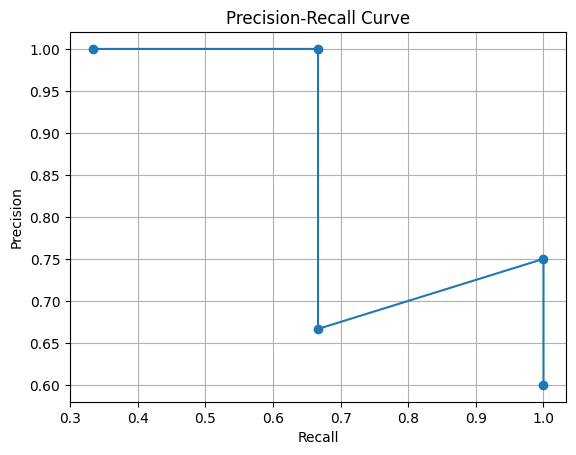

In [2]:

## 📊 Построение Precision-Recall кривой

import numpy as np
import matplotlib.pyplot as plt

# Предсказания: [confidence, TP or FP]
predictions = [
    (0.9, 1),
    (0.8, 1),
    (0.7, 0),
    (0.6, 1),
    (0.5, 0),
]

# Сортировка по confidence
predictions.sort(reverse=True)

tp = 0
fp = 0
precisions = []
recalls = []

num_gt = 3  # допустим, в датасете 3 объекта

for conf, is_tp in predictions:
    if is_tp:
        tp += 1
    else:
        fp += 1
    precision = tp / (tp + fp)
    recall = tp / num_gt
    precisions.append(precision)
    recalls.append(recall)

plt.figure()
plt.plot(recalls, precisions, marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()


In [3]:

## 📈 Вычисление AP по PR кривой (прямоугольное приближение)

def average_precision(recalls, precisions):
    ap = 0.0
    for i in range(1, len(recalls)):
        ap += (recalls[i] - recalls[i - 1]) * precisions[i]
    return ap

average_precision(recalls, precisions)


0.5833333333333333


## 🔁 Реалистичный пример: автоматическое определение TP/FP

Здесь мы имитируем реальную ситуацию:
- есть ground truth боксы
- есть предсказанные боксы с confidence
- мы автоматически определяем TP и FP на основе IoU и порога IoU

Подход:
1. Сравниваем каждый предсказанный bbox с GT по IoU
2. Назначаем TP, если IoU > 0.5 и GT еще не занят
3. Остальные считаем FP


Предсказания с метками TP/FP:
Confidence: 0.95, TP
Confidence: 0.9, TP
Confidence: 0.8, FP
Confidence: 0.7, TP
Confidence: 0.6, FP


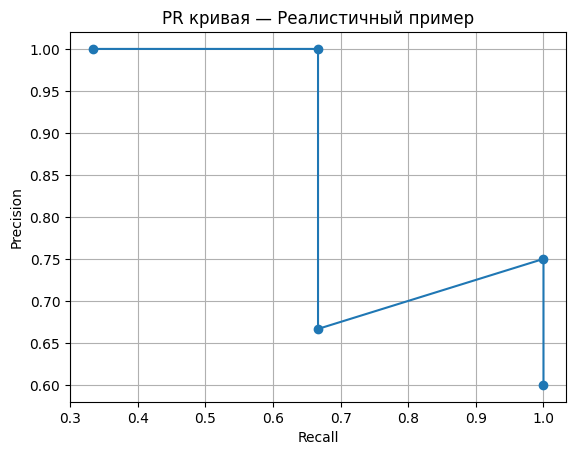

In [4]:
import numpy as np

def compute_iou(box1, box2):
    x_left = max(box1[0], box2[0])
    y_top = max(box1[1], box2[1])
    x_right = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    inter = (x_right - x_left) * (y_bottom - y_top)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - inter
    return inter / union

# Ground truth
gt_boxes = [
    [50, 50, 150, 150],
    [200, 200, 300, 300],
    [120, 50, 220, 150]
]

# Предсказания: [x1, y1, x2, y2, confidence]
pred_boxes = [
    [55, 55, 145, 145, 0.95],  # TP
    [205, 205, 295, 295, 0.9],  # TP
    [100, 100, 180, 180, 0.8],  # FP
    [120, 55, 215, 145, 0.7],   # TP
    [50, 50, 150, 150, 0.6],    # FP (дубликат)
]

# Сортировка по убыванию confidence
pred_boxes.sort(key=lambda x: x[4], reverse=True)

matched_gt = set()
results = []  # (confidence, is_tp)

for pred in pred_boxes:
    pred_box = pred[:4]
    conf = pred[4]
    best_iou = 0
    best_gt_idx = -1

    for idx, gt in enumerate(gt_boxes):
        iou = compute_iou(pred_box, gt)
        if iou > best_iou:
            best_iou = iou
            best_gt_idx = idx

    if best_iou >= 0.5 and best_gt_idx not in matched_gt:
        matched_gt.add(best_gt_idx)
        results.append((conf, 1))  # TP
    else:
        results.append((conf, 0))  # FP

print("Предсказания с метками TP/FP:")
for conf, label in results:
    print(f"Confidence: {conf}, {'TP' if label else 'FP'}")

# Построение PR кривой
tp = 0
fp = 0
precisions = []
recalls = []
num_gt = len(gt_boxes)

for conf, is_tp in results:
    if is_tp:
        tp += 1
    else:
        fp += 1
    precisions.append(tp / (tp + fp))
    recalls.append(tp / num_gt)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(recalls, precisions, marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR кривая — Реалистичный пример')
plt.grid(True)
plt.show()



## 🧪 OpenCV: Визуализация TP / FP боксов

Чтобы визуально анализировать качество предсказаний:
- Нарисуем ground truth (зелёным)
- Нарисуем TP (синим)
- Нарисуем FP (красным)
- Покажем IoU над bbox

Эта визуализация помогает сразу понять:
- Какие объекты пропущены (FN)
- Где были FP
- Как качественно модель локализует объекты


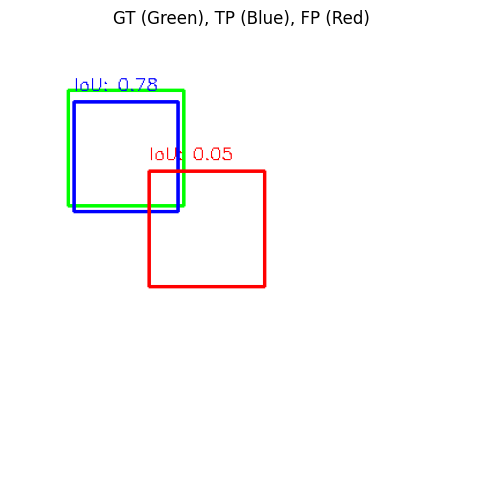

In [5]:

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Создадим пустое изображение
image = np.ones((400, 400, 3), dtype=np.uint8) * 255

# Ground truth bbox
gt_box = [50, 50, 150, 150]
cv2.rectangle(image, (gt_box[0], gt_box[1]), (gt_box[2], gt_box[3]), (0, 255, 0), 2)  # Green

# Предсказанные боксы: [x1, y1, x2, y2, confidence]
pred_boxes = [
    [55, 60, 145, 155, 0.9],  # TP (высокий IoU)
    [120, 120, 220, 220, 0.6],  # FP (низкий IoU)
]

for box in pred_boxes:
    pred = box[:4]
    iou = compute_iou(gt_box, pred)
    color = (255, 0, 0) if iou >= 0.5 else (0, 0, 255)  # TP: blue, FP: red
    cv2.rectangle(image, (pred[0], pred[1]), (pred[2], pred[3]), color, 2)
    cv2.putText(image, f"IoU: {iou:.2f}", (pred[0], pred[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

# Отобразим изображение
plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("GT (Green), TP (Blue), FP (Red)")
plt.axis(False)
plt.show()



## 🧮 Линейная алгебра: Собственные значения и векторы

### 🔍 Определение

Пусть дана квадратная матрица \( A \in \mathbb{R}^{n \times n} \).  
Вектор \( \vec{v} \) называется **собственным вектором**, если:

$$
A \vec{v} = \lambda \vec{v}
$$

где:
- \( \lambda \) — **собственное значение**
- \( \vec{v} \ne 0 \) — собственный вектор

Это означает, что при применении линейного преобразования \( A \) вектор \( \vec{v} \) **не меняет направление**, только масштабируется.

---

### 📐 Геометрический смысл

- Собственные векторы показывают **направления инвариантности**.
- В компьютерном зрении это важно, например:
  - PCA (главные компоненты) — для снижения размерности
  - Harris Corner Detection
  - Диагонализация ковариационных матриц

---

### 🧠 Как находить

Для матрицы \( A \):

$$
\det(A - \lambda I) = 0
$$

Решая это уравнение по \( \lambda \), мы находим собственные значения.

Затем подставляем каждое \( \lambda \) и решаем \( (A - \lambda I)\vec{v} = 0 \), чтобы найти векторы.

---

### 🧪 Пример


In [6]:

import numpy as np

# Матрица
A = np.array([[2, 1],
              [1, 2]])

# Вычислим собственные значения и векторы
eigvals, eigvecs = np.linalg.eig(A)

print("Собственные значения:", eigvals)
print("Собственные векторы (столбцы):\n", eigvecs)

# Проверим A v = lambda v
for i in range(len(eigvals)):
    Av = A @ eigvecs[:, i]
    lv = eigvals[i] * eigvecs[:, i]
    print(f"\nПроверка для λ = {eigvals[i]:.2f}:")
    print("A @ v =", Av)
    print("λ * v =", lv)


Собственные значения: [3. 1.]
Собственные векторы (столбцы):
 [[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]

Проверка для λ = 3.00:
A @ v = [2.12132034 2.12132034]
λ * v = [2.12132034 2.12132034]

Проверка для λ = 1.00:
A @ v = [-0.70710678  0.70710678]
λ * v = [-0.70710678  0.70710678]
